# Punzi and Signal Purity Scans

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
from joblib import load
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [2]:
version = '7.0.2'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = df = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = df = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

## Load Models

In [3]:
nn = tf.keras.models.load_model(f'../neural_network/models/v{version}_tune')
old_nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
knn = load(f'../classification_methods/models/KNN_{version}_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_{version}_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_{version}_tune.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'OLDNN': old_nn}

2022-03-23 10:32:54.770681: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-23 10:32:54.793268: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Signal Purity

In [35]:
def get_purity(labels, predictions, p):
    # Of everything I selected how much was correctly ID'd as signal?
    purities = []
    for j in p:
        classes = np.where(predictions.flatten() > j, 1, 0).flatten()
        total_selected_events = np.count_nonzero(classes)
        purity = np.count_nonzero(np.logical_and(classes, labels))/total_selected_events
        purities.append(purity)
    return np.array(purities)

# Something broken here as I am selecting less events than i got total correct at the moment....

## Punzi Figure-of-Merit

In [76]:
def quadratic(x, N, c):
    # Fixed a, b and c from before
    # c = 9.75510769e+04
    # N = 2.44251065e-01
    return N*(2.26331016e-03*(x**2) + (-2.95953991e+01*x) + c)

In [149]:
def get_punzi(labels, predictions, masses, p, a=5, sregion=[5200, 5800], nbins=60):
    from scipy.integrate import quad
    from scipy.optimize import curve_fit
    punzis = []
    for j in p:
        classes = np.where(predictions > j, 1, 0).flatten()
        cut_masses = np.array([m for i, m in enumerate(masses) if (classes[i] == 1) and (labels[i] == 0)])
        # What are the masses of all the events which we incorrectly said were signal
        h, bins = np.histogram(cut_masses-5500, bins=nbins)
        # shift the cut_masses by 5.5 GeV for testing
        
        efficiency = np.count_nonzero(np.logical_and(classes, labels))/np.count_nonzero(labels)
        # The number of signal events correctly identified divied by the number of signal events 
        #popt = curve_fit(quadratic, [np.mean(bins[i:i+2]) for i in range(len(bins)-1)], h, [2.44251065e-01], np.sqrt(h))[0]
        #nbg = quad(quadratic, sregion[0], sregion[1], args=(popt[0]))[0]
        #punzi = efficiency/(a/2 + np.sqrt(nbg))
        #punzis.append(punzi)
    return np.array(punzis), h, bins

## Testing Models

In [58]:
test_range = np.linspace(0.1, 0.95, 200)
test_model = 'NN'

In [150]:
_, h, bins = get_punzi(y_test.to_numpy(), models[test_model].predict(X_test), test['Lb_M'].to_numpy(), [0.5], nbins=40)

In [51]:
purities = get_purity(y_test.to_numpy(), models[test_model].predict(X_test), test_range)

# Find the position closest to 95%
cut_threshold_position = np.argmin(np.abs(purities - 0.95))

In [153]:
def my_func(x, a, b, c):
    return a*((x-b)**2)+c

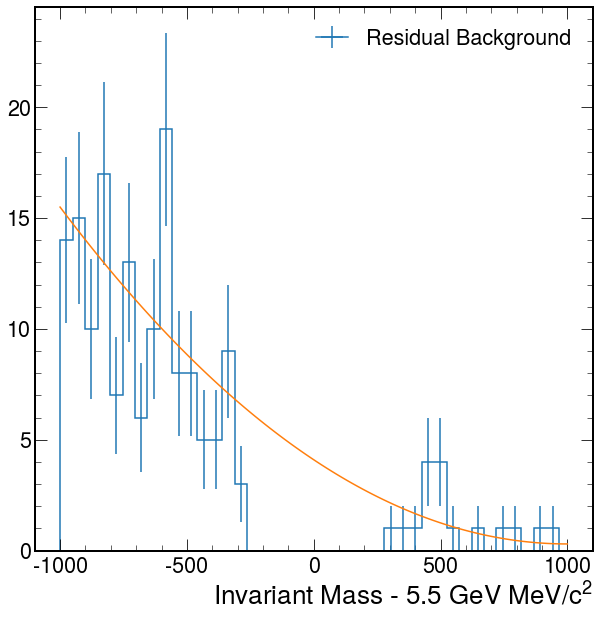

In [162]:
fr = np.linspace(-1000, 1000, 100)
fig, ax = plt.subplots(1, 1)
hep.histplot(h, bins, yerr=np.sqrt(h), ax=ax, label='Residual Background')
ax.plot(fr, my_func(fr, 3.8e-6, 1e+3, 0.3))
plt.xlabel(r'Invariant Mass - 5.5 GeV $MeV/c^2$')
plt.legend()
plt.show()

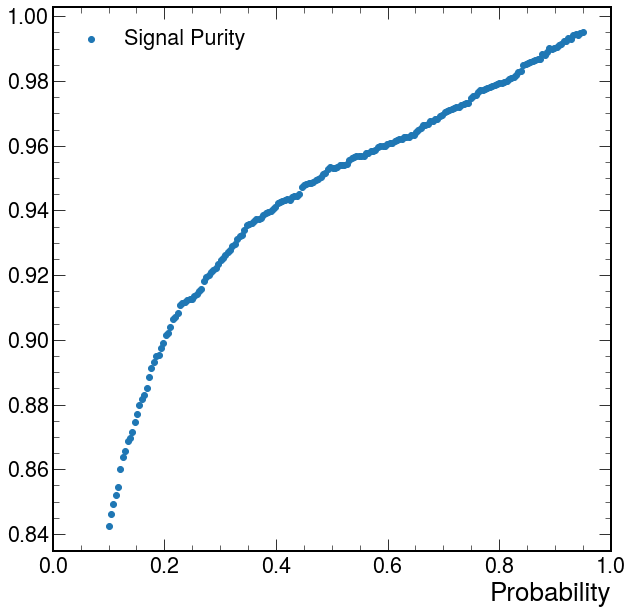

In [56]:
fig, ax = plt.subplots(1, 1)
ax.scatter(test_range, purities, label='Signal Purity')
ax.set_xlim(0, 1)
plt.xlabel('Probability')
plt.legend()
plt.show()